# Ejercicio 1 Skip-grams
Modifica el código para que se pueda seleccionar el tamaño de la ventana L y realiza un pequeño estudio sobre cómo esto afecta a los embeddings obtenidos.



## Semilla de aleatoriedad

In [ ]:
import os
# set before importing pytorch to avoid all non-deterministic operations on GPU
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

import random
import numpy as np
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(True)

set_seed(44)  # to ensure reproducibility

## Preproceso

### Corpus

In [ ]:
corpus = """
    perro gato ratón pájaro .
    manzana naranja pera uva .
    azul rojo verde amarillo .
    guitarra piano violín flauta .
    perro gato .
    uva pera manzana .
    amarillo rojo .
    piano violín .
    ratón pájaro gato .
    verde azul amarillo uva .
    perro .
    naranja .
    azul piano verde .
    flauta guitarra .
    gato ratón perro .
    manzana naranja uva pera .
    rojo amarillo azul .
    violín piano flauta .
    pájaro ratón gato perro .
    uva manzana naranja .
    verde azul .
    guitarra violín piano .
    perro pájaro .
    pera uva manzana naranja .
    amarillo verde rojo azul .
    flauta piano .
    gato ratón pájaro .
    naranja uva manzana pera .
    azul rojo verde .
    violín flauta guitarra piano .
"""

### Preproceso del vocabulario

In [ ]:
corpus = corpus.split()  # split by space
word_list = list(set(corpus))  # removes duplicates
word_index = {w: i for i, w in enumerate(word_list)}  # word from index
index_word = {i: w for i, w in enumerate(word_list)}  # index from word
voc_size = len(word_list)  # number of words

print(f"word_index = {word_index}")
print(f"index_word = {index_word}")
print(f"voc_size = {voc_size}")

word_index = {'amarillo': 0, 'uva': 1, 'guitarra': 2, 'flauta': 3, 'gato': 4, 'azul': 5, 'piano': 6, 'pera': 7, 'verde': 8, 'naranja': 9, 'manzana': 10, '.': 11, 'perro': 12, 'rojo': 13, 'ratón': 14, 'violín': 15, 'pájaro': 16}
index_word = {0: 'amarillo', 1: 'uva', 2: 'guitarra', 3: 'flauta', 4: 'gato', 5: 'azul', 6: 'piano', 7: 'pera', 8: 'verde', 9: 'naranja', 10: 'manzana', 11: '.', 12: 'perro', 13: 'rojo', 14: 'ratón', 15: 'violín', 16: 'pájaro'}
voc_size = 17


### Creación del dataset

In [ ]:
'''
k = 2  # ratio of negative samples to positive samples

skip_grams_positive = []
for i in range(1, len(corpus) - 1):
    target = word_index[corpus[i]]
    context = [word_index[corpus[i - 1]], word_index[corpus[i + 1]]]
    for c in context:
        skip_grams_positive.append([target, c])

skip_grams_negative = []
for i in range(len(corpus)):
    target = word_index[corpus[i]]
    context = [word_index[i] for i in random.sample(word_list,2*k)]
    for c in context:
        skip_grams_negative.append([target, c])

print(f"Some positive samples: {skip_grams_positive[:3]}")
print(f"Some negative samples: {skip_grams_negative[:3]}")
print(f"Some positive samples with tokens: {', '.join([f'({index_word[i[0]]},{index_word[i[1]]})' for i in skip_grams_positive[:3]])}")
print(f"Some negative samples with tokens: {', '.join([f'({index_word[i[0]]},{index_word[i[1]]})' for i in skip_grams_negative[:3]])}")
'''

def generate_skipgrams(corpus, window_size, k):
    skip_grams_positive = []
    skip_grams_negative = []

    for i in range(window_size, len(corpus) - window_size):
        target = word_index[corpus[i]]
        context = [word_index[corpus[i - j]] for j in range(1, window_size + 1)] + \
                  [word_index[corpus[i + j]] for j in range(1, window_size + 1)]

        # Positive
        for c in context:
            skip_grams_positive.append([target, c])

        # Negative
        neg_context = [word_index[i] for i in random.sample(word_list, 2 * k)]
        for c in neg_context:
            skip_grams_negative.append([target, c])

    return skip_grams_positive, skip_grams_negative


L = 2
k = 2

skip_grams_positive, skip_grams_negative = generate_skipgrams(corpus, L, k)

print(f"Some positive samples: {skip_grams_positive[:3]}")
print(f"Some negative samples: {skip_grams_negative[:3]}")
print(f"Some positive samples with tokens: {', '.join([f'({index_word[i[0]]},{index_word[i[1]]})' for i in skip_grams_positive[:3]])}")
print(f"Some negative samples with tokens: {', '.join([f'({index_word[i[0]]},{index_word[i[1]]})' for i in skip_grams_negative[:3]])}")


Some positive samples: [[14, 4], [14, 12], [14, 16]]
Some negative samples: [[14, 13], [14, 3], [14, 2]]
Some positive samples with tokens: (ratón,gato), (ratón,perro), (ratón,pájaro)
Some negative samples with tokens: (ratón,rojo), (ratón,flauta), (ratón,guitarra)


## Generación del mini-batch

In [ ]:
import numpy as np

def random_batch(skip_grams_positive, skip_grams_negative, batch_size):
    random_target = []
    random_context= []
    random_output = []

    positive_size = batch_size//(k+1)

    random_index = np.random.choice(range(len(skip_grams_positive)), positive_size, replace=True)
    for i in random_index:
        random_target.append(skip_grams_positive[i][0])
        random_context.append(skip_grams_positive[i][1])
        random_output.append(1)  # desired output = 1

    random_index = np.random.choice(range(len(skip_grams_negative)), positive_size*k, replace=True)
    for i in random_index:
        random_target.append(skip_grams_negative[i][0])
        random_context.append(skip_grams_negative[i][1])
        random_output.append(0)  # desired output = 0

    return random_target, random_context, random_output

## Definición del modelo

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Model
class Word2Vec(nn.Module):
    def __init__(self, voc_size, embedding_size):
        super().__init__()
        self.W = nn.Embedding(voc_size, embedding_size)  # target matrix
        self.C = nn.Embedding(voc_size, embedding_size)  # context matrix

    def forward(self, Xt, Xc):
        w = self.W(Xt)
        c = self.C(Xc)
        dot = torch.einsum('ij,ji->i',w,c.t())
        output_layer = F.sigmoid(dot)
        return output_layer

## Entrenamiento

In [ ]:

import torch.optim as optim

batch_size = 32
embedding_size = 2
lr = 0.01

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Word2Vec(voc_size, embedding_size).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

model.train()

training_steps = 2500
eval_steps = 250

# Training
for i in range(training_steps):
    input_w_batch, input_c_batch, target_batch = random_batch(skip_grams_positive, skip_grams_negative, batch_size)
    input_w_batch = torch.tensor(input_w_batch,dtype=torch.long).to(device)
    input_c_batch = torch.tensor(input_c_batch,dtype=torch.long).to(device)
    target_batch = torch.tensor(target_batch,dtype=torch.float32).to(device)

    optimizer.zero_grad()
    output = model(input_w_batch,input_c_batch)

    # output : [batch_size], target_batch : [batch_size]
    loss = criterion(output, target_batch)
    if i % eval_steps == 0:
        print(f'Step [{i}/{training_steps}], loss: {loss.item():.4f}')

    loss.backward()
    optimizer.step()

print(f'Step [{training_steps}/{training_steps}], loss: {loss.item():.4f}')

Step [0/2500], loss: 0.8140
Step [250/2500], loss: 0.7073
Step [500/2500], loss: 0.5512
Step [750/2500], loss: 0.6065
Step [1000/2500], loss: 0.5761
Step [1250/2500], loss: 0.5175
Step [1500/2500], loss: 0.6221
Step [1750/2500], loss: 0.5966
Step [2000/2500], loss: 0.5242
Step [2250/2500], loss: 0.4759
Step [2500/2500], loss: 0.5672


## Visualización de los embbedings

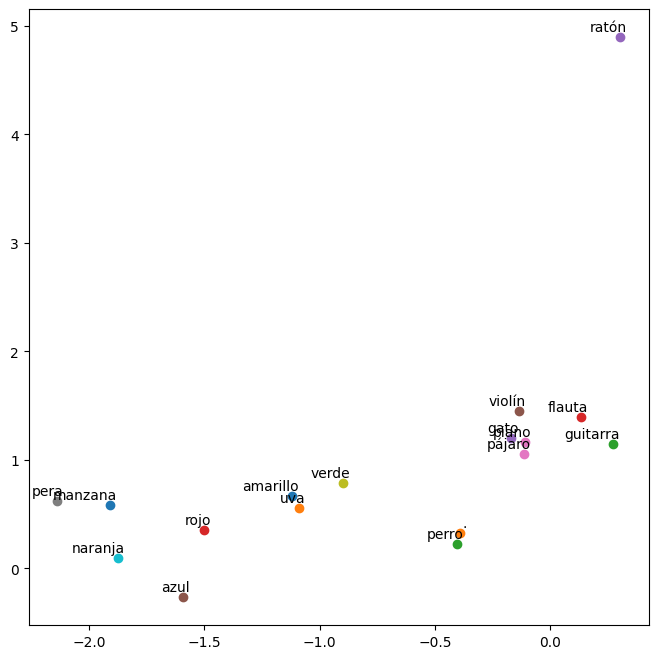

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))  # square figure
for i, label in enumerate(word_list):
    W, C = model.parameters()  # W, _ = model.parameters() would be more appropriate
    x, y = W[i][0].item(), W[i][1].item()
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()


## Entrenamiento y visualización para diferentes valores de la ventana L

Training for window size L=1
Step [0/2500] for window size L=1, loss: 0.7332
Step [250/2500] for window size L=1, loss: 0.6692
Step [500/2500] for window size L=1, loss: 0.6024
Step [750/2500] for window size L=1, loss: 0.4983
Step [1000/2500] for window size L=1, loss: 0.5058
Step [1250/2500] for window size L=1, loss: 0.4800
Step [1500/2500] for window size L=1, loss: 0.4005
Step [1750/2500] for window size L=1, loss: 0.4345
Step [2000/2500] for window size L=1, loss: 0.4236
Step [2250/2500] for window size L=1, loss: 0.5497
Final loss for window size L=1: 0.4947
Training for window size L=2
Step [0/2500] for window size L=2, loss: 1.1425
Step [250/2500] for window size L=2, loss: 0.6384
Step [500/2500] for window size L=2, loss: 0.6405
Step [750/2500] for window size L=2, loss: 0.5714
Step [1000/2500] for window size L=2, loss: 0.5229
Step [1250/2500] for window size L=2, loss: 0.4579
Step [1500/2500] for window size L=2, loss: 0.5367
Step [1750/2500] for window size L=2, loss: 0.46

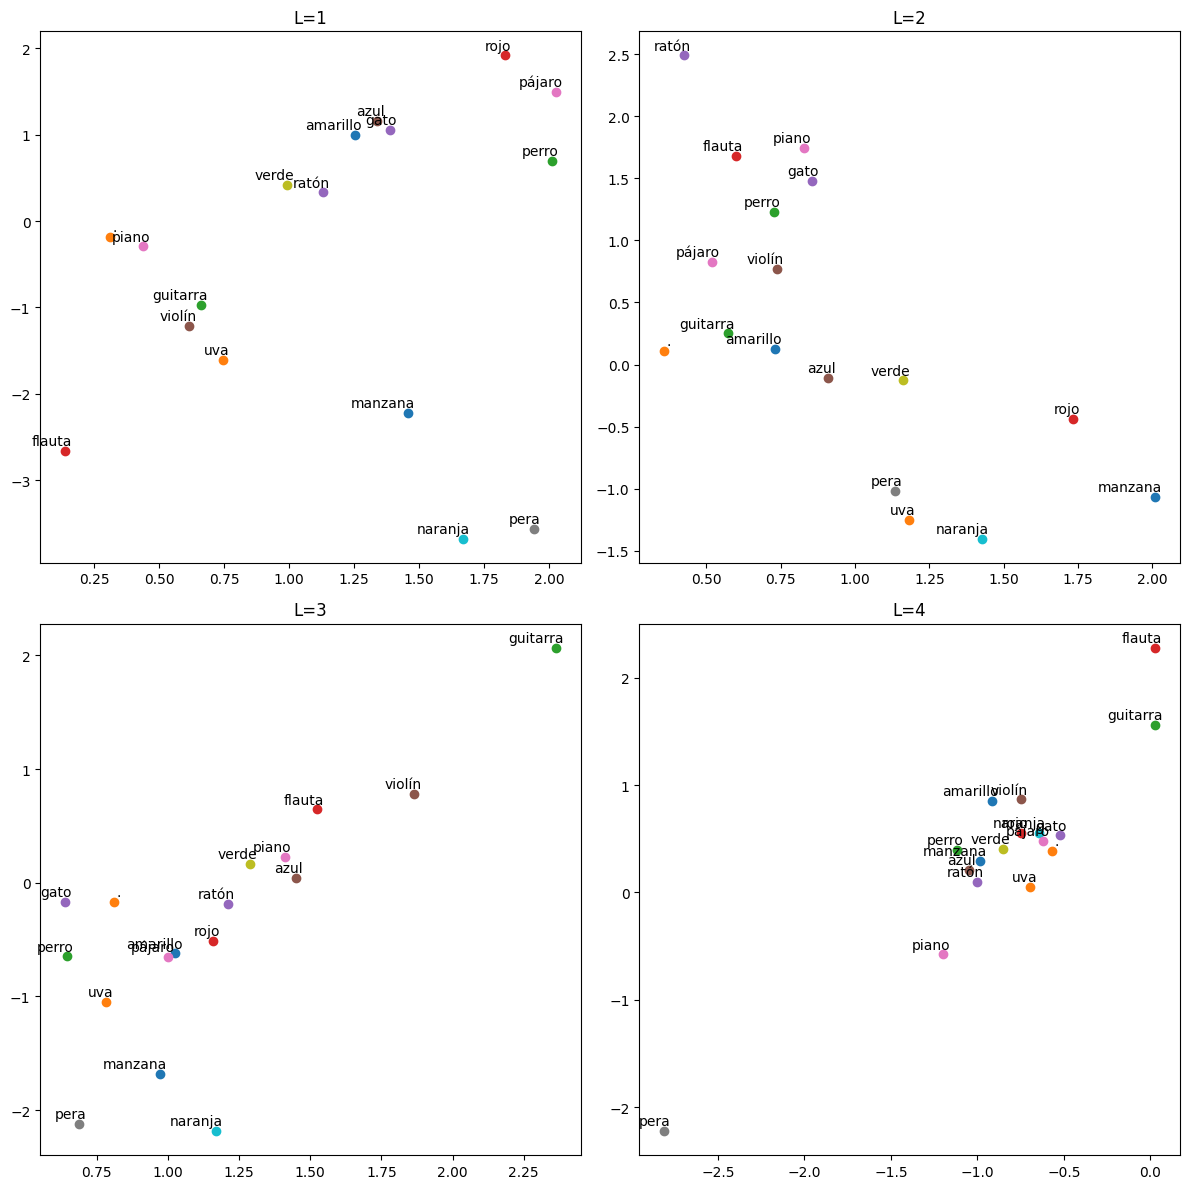

In [ ]:
window_sizes = [1, 2, 3, 4]

batch_size = 32
embedding_size = 2
lr = 0.01

training_steps = 2500
eval_steps = 250

device = 'cuda' if torch.cuda.is_available() else 'cpu'

import math

# Graficos
num_plots = len(window_sizes)
num_cols = math.ceil(math.sqrt(num_plots))
num_rows = math.ceil(num_plots / num_cols)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))

for i, L in enumerate(window_sizes):
    print(f"Training for window size L={L}")

    skip_grams_positive, skip_grams_negative = generate_skipgrams(corpus, L, k)

    # Entrenamiento
    model = Word2Vec(voc_size, embedding_size).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    for step in range(training_steps):
        input_w_batch, input_c_batch, target_batch = random_batch(skip_grams_positive, skip_grams_negative, batch_size)
        input_w_batch = torch.tensor(input_w_batch, dtype=torch.long).to(device)
        input_c_batch = torch.tensor(input_c_batch, dtype=torch.long).to(device)
        target_batch = torch.tensor(target_batch, dtype=torch.float32).to(device)

        optimizer.zero_grad()
        output = model(input_w_batch, input_c_batch)
        loss = criterion(output, target_batch)
        if step % eval_steps == 0:
            print(f'Step [{step}/{training_steps}] for window size L={L}, loss: {loss.item():.4f}')
        loss.backward()
        optimizer.step()

    print(f'Final loss for window size L={L}: {loss.item():.4f}')

    # Graficar embbedings
    ax = axs[i // num_cols, i % num_cols]
    for j, label in enumerate(word_list):
        W, C = model.parameters()
        x, y = W[j][0].item(), W[j][1].item()
        ax.scatter(x, y)
        ax.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    ax.set_title(f"L={L}")

plt.tight_layout()
plt.show()


## Cálculo de la similitud

In [ ]:
cos = nn.CosineSimilarity(dim=0)

uva = model.W(torch.tensor(word_index['uva']))
manzana = model.W(torch.tensor(word_index['manzana']))
gato = model.W(torch.tensor(word_index['gato']))

print(f"Cosine similarity between 'uva' and 'manzana' is {cos(uva, manzana).item():.3f}")
print(f"Cosine similarity between 'uva' and 'gato' is {cos(uva, gato).item():.3f}")

Cosine similarity between 'uva' and 'manzana' is 0.976
Cosine similarity between 'uva' and 'gato' is 0.751


Se han realizado diferentes entrenamientos con distintos valores de la ventana (L=1, L=2, L=3, L=4). Se puede observar como con los valores de ventana más pequeños las palabras están más dispersas en el espacio bidimensional. Por otro lado, cuando aumenta dicho valor, existe una mayor agrupación de las palabras. Se puede decir que cuanto mayores son las ventanas los embeddings tienen más contexto semántico y menos sintáctico, y a su vez, se introduce más ruido.

# Ejercicio 2 Skip-grams
Sustituye la parte del código que usa la notación de Einstein por una multiplicación convencional de matrices seguida de una operación que se quede con los valores que nos interesan. Compara los tiempos de ejecución de ambas implementaciones.

## Semilla de aleatoriedad

In [ ]:
import os
# set before importing pytorch to avoid all non-deterministic operations on GPU
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

import random
import numpy as np
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(True)

set_seed(44)  # to ensure reproducibility

## Preproceso

### Corpus

In [ ]:
corpus = """
    perro gato ratón pájaro .
    manzana naranja pera uva .
    azul rojo verde amarillo .
    guitarra piano violín flauta .
    perro gato .
    uva pera manzana .
    amarillo rojo .
    piano violín .
    ratón pájaro gato .
    verde azul amarillo uva .
    perro .
    naranja .
    azul piano verde .
    flauta guitarra .
    gato ratón perro .
    manzana naranja uva pera .
    rojo amarillo azul .
    violín piano flauta .
    pájaro ratón gato perro .
    uva manzana naranja .
    verde azul .
    guitarra violín piano .
    perro pájaro .
    pera uva manzana naranja .
    amarillo verde rojo azul .
    flauta piano .
    gato ratón pájaro .
    naranja uva manzana pera .
    azul rojo verde .
    violín flauta guitarra piano .
"""

### Preproceso del vocabulario

In [ ]:
corpus = corpus.split()  # split by space
word_list = list(set(corpus))  # removes duplicates
word_index = {w: i for i, w in enumerate(word_list)}  # word from index
index_word = {i: w for i, w in enumerate(word_list)}  # index from word
voc_size = len(word_list)  # number of words

print(f"word_index = {word_index}")
print(f"index_word = {index_word}")
print(f"voc_size = {voc_size}")

word_index = {'pájaro': 0, 'pera': 1, 'azul': 2, 'amarillo': 3, 'violín': 4, 'ratón': 5, 'piano': 6, 'perro': 7, 'manzana': 8, '.': 9, 'uva': 10, 'gato': 11, 'verde': 12, 'flauta': 13, 'naranja': 14, 'guitarra': 15, 'rojo': 16}
index_word = {0: 'pájaro', 1: 'pera', 2: 'azul', 3: 'amarillo', 4: 'violín', 5: 'ratón', 6: 'piano', 7: 'perro', 8: 'manzana', 9: '.', 10: 'uva', 11: 'gato', 12: 'verde', 13: 'flauta', 14: 'naranja', 15: 'guitarra', 16: 'rojo'}
voc_size = 17


### Creación del dataset

In [ ]:
k = 2  # ratio of negative samples to positive samples

skip_grams_positive = []
for i in range(1, len(corpus) - 1):
    target = word_index[corpus[i]]
    context = [word_index[corpus[i - 1]], word_index[corpus[i + 1]]]
    for c in context:
        skip_grams_positive.append([target, c])

skip_grams_negative = []
for i in range(len(corpus)):
    target = word_index[corpus[i]]
    context = [word_index[i] for i in random.sample(word_list,2*k)]
    for c in context:
        skip_grams_negative.append([target, c])

print(f"Some positive samples: {skip_grams_positive[:3]}")
print(f"Some negative samples: {skip_grams_negative[:3]}")
print(f"Some positive samples with tokens: {', '.join([f'({index_word[i[0]]},{index_word[i[1]]})' for i in skip_grams_positive[:3]])}")
print(f"Some negative samples with tokens: {', '.join([f'({index_word[i[0]]},{index_word[i[1]]})' for i in skip_grams_negative[:3]])}")

Some positive samples: [[11, 7], [11, 5], [5, 11]]
Some negative samples: [[7, 13], [7, 3], [7, 2]]
Some positive samples with tokens: (gato,perro), (gato,ratón), (ratón,gato)
Some negative samples with tokens: (perro,flauta), (perro,amarillo), (perro,azul)


## Generación del mini-batch

In [ ]:
import numpy as np

def random_batch(skip_grams_positive, skip_grams_negative, batch_size):
    random_target = []
    random_context= []
    random_output = []

    positive_size = batch_size//(k+1)

    random_index = np.random.choice(range(len(skip_grams_positive)), positive_size, replace=True)
    for i in random_index:
        random_target.append(skip_grams_positive[i][0])
        random_context.append(skip_grams_positive[i][1])
        random_output.append(1)  # desired output = 1

    random_index = np.random.choice(range(len(skip_grams_negative)), positive_size*k, replace=True)
    for i in random_index:
        random_target.append(skip_grams_negative[i][0])
        random_context.append(skip_grams_negative[i][1])
        random_output.append(0)  # desired output = 0

    return random_target, random_context, random_output

## Definición del modelo

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

'''
# Model
class Word2Vec(nn.Module):
    def __init__(self, voc_size, embedding_size):
        super().__init__()
        self.W = nn.Embedding(voc_size, embedding_size)  # target matrix
        self.C = nn.Embedding(voc_size, embedding_size)  # context matrix

    def forward(self, Xt, Xc):
        w = self.W(Xt)
        c = self.C(Xc)
        dot = torch.einsum('ij,ji->i',w,c.t())
        output_layer = F.sigmoid(dot)
        return output_layer

'''

class Word2Vec(nn.Module):
    def __init__(self, voc_size, embedding_size):
        super().__init__()
        self.W = nn.Embedding(voc_size, embedding_size)  # target matrix
        self.C = nn.Embedding(voc_size, embedding_size)  # context matrix

    def forward(self, Xt, Xc):
        w = self.W(Xt)
        c = self.C(Xc)

        # Multiplicación de matrices
        dot = torch.matmul(w, c.t())

        # Extracción de los elementos
        diag_indices = torch.arange(dot.size(0), device=dot.device)
        d = dot[diag_indices, diag_indices]

        output_layer = F.sigmoid(d)
        return output_layer

## Entrenamiento

In [ ]:

import torch.optim as optim

batch_size = 32
embedding_size = 2
lr = 0.01

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Word2Vec(voc_size, embedding_size).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

model.train()

training_steps = 2500
eval_steps = 250

# Training
for i in range(training_steps):
    input_w_batch, input_c_batch, target_batch = random_batch(skip_grams_positive, skip_grams_negative, batch_size)
    input_w_batch = torch.tensor(input_w_batch,dtype=torch.long).to(device)
    input_c_batch = torch.tensor(input_c_batch,dtype=torch.long).to(device)
    target_batch = torch.tensor(target_batch,dtype=torch.float32).to(device)

    optimizer.zero_grad()
    output = model(input_w_batch,input_c_batch)

    # output : [batch_size], target_batch : [batch_size]
    loss = criterion(output, target_batch)
    if i % eval_steps == 0:
        print(f'Step [{i}/{training_steps}], loss: {loss.item():.4f}')

    loss.backward()
    optimizer.step()

print(f'Step [{training_steps}/{training_steps}], loss: {loss.item():.4f}')

Step [0/2500], loss: 0.9358
Step [250/2500], loss: 0.6520
Step [500/2500], loss: 0.5953
Step [750/2500], loss: 0.6807
Step [1000/2500], loss: 0.5939
Step [1250/2500], loss: 0.5061
Step [1500/2500], loss: 0.6142
Step [1750/2500], loss: 0.5036
Step [2000/2500], loss: 0.4902
Step [2250/2500], loss: 0.5398
Step [2500/2500], loss: 0.4235


## Visualización de los embbedings

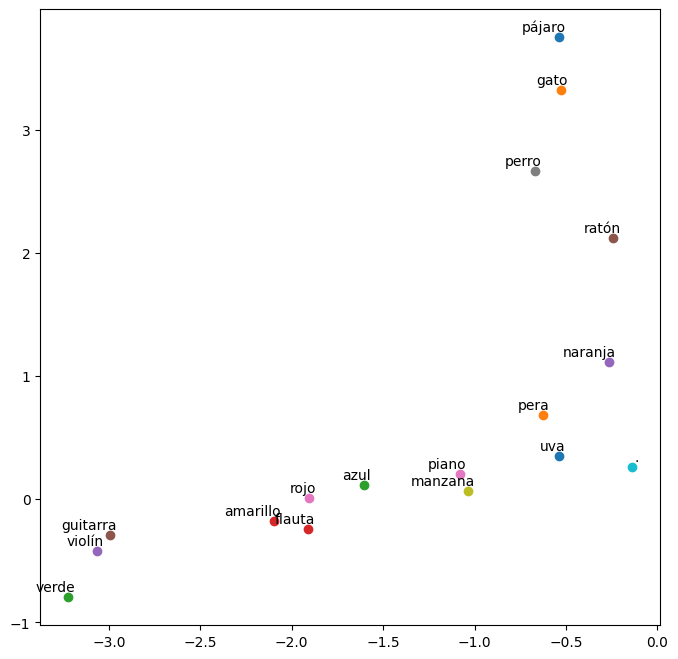

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))  # square figure
for i, label in enumerate(word_list):
    W, C = model.parameters()  # W, _ = model.parameters() would be more appropriate
    x, y = W[i][0].item(), W[i][1].item()
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()


## Cálculo de la similitud

In [ ]:
cos = nn.CosineSimilarity(dim=0)

uva = model.W(torch.tensor(word_index['uva']))
manzana = model.W(torch.tensor(word_index['manzana']))
gato = model.W(torch.tensor(word_index['gato']))

print(f"Cosine similarity between 'uva' and 'manzana' is {cos(uva, manzana).item():.3f}")
print(f"Cosine similarity between 'uva' and 'gato' is {cos(uva, gato).item():.3f}")

Cosine similarity between 'uva' and 'manzana' is 0.872
Cosine similarity between 'uva' and 'gato' is 0.668


## Tiempos de ejecución

La primera ejecución tarda aproximadamente 8s durante el entrenamiento del modelo.

La segunda ejecución, la de la multiplicación de matrices convencionales tarda aproximadamente 3s.

Esto supone mas del doble de velocidad de entrenamiento.

Nota: estos resultados se han obtenido en la ejecución del código en Colab.